In [1]:
using Distributions, TimeIt, ProgressMeter, PyPlot, JLD
include("zz_structures_DuLuSuSe.jl")
include("mbsampler.jl")

get_clustering (generic function with 1 method)

#### Load data:

In [2]:
d, Nobs = 25_000, 30_000
X = sprandn(d, Nobs, 5e-2)
X[1,:] = ones(Nobs)
nz = 250
ξ_true = spzeros(d)
ξ_true[1] = 3*rand()
nzind = sample(1:d, nz)
ξ_true[nzind[1:Int(nz/2)]] = rand(Uniform(7,10),Int(nz/2))
ξ_true[nzind[Int(nz/2)+1:end]] = -rand(Uniform(7,10),Int(nz/2));
y = [rand(Binomial(1, 1/(1+exp(-X[:,n]'ξ_true)))) for n in 1:Nobs];

#### Define prior:

In [3]:
σ02 = 1
prior = SS_prior(d, σ02);

#### Define model:

In [4]:
my_ll = ll_logistic_sp(X,y);
my_model = model(my_ll, prior);

#### Define minibatch sampler:

In [6]:
mb_size = 150
weights_het = spzeros(d, Nobs)
@showprogress for i in 2:d
    nzind = X[i,:].nzind
    weights_het[i,nzind] = abs.(X[i,nzind])./sum(abs.(X[i,nzind]))
end

prob_het = 0.98
gs = Array{mbsampler}(d)
gs[1] = umbsampler(Nobs, mb_size)
@showprogress for i in 2:d 
    gs[i] = spwumbsampler(Nobs, mb_size, weights_het[i,:], prob_het)
end
gs_list = mbsampler_list(d,gs);

Progress:   5%|██                                       |  ETA: 3:58:55

LoadError: [91mInterruptException:[39m

ERROR (unhandled task failure): InterruptException:
Stacktrace:
 [1] process_events at ./libuv.jl:82 [inlined]
 [2] wait() at ./event.jl:216
 [3] wait(::Condition) at ./event.jl:27
 [4] stream_wait(::Timer, ::Condition, ::Vararg{Condition,N} where N) at ./stream.jl:42
 [5] wait(::Timer) at ./event.jl:357
 [6] (::Base.##302#303{IJulia.#send_stderr,Timer})() at ./event.jl:430


#### Define output scheduler:

In [11]:
k = 100
A_xi = spzeros(k,d)
for i in 1:k 
    A_xi[i,i] = 1.
end

In [12]:
bb_fixed = linear_bound(my_model.ll, my_model.pr, gs_list)

Progress: 100%|█████████████████████████████████████████| Time: 0:02:15


linear_bound([30000.0, 2.01233e6, 6.28657e5, 3.85265e5, 1.70846e6, 1.59204e6, 7.05855e5, 322597.0, 276204.0, 8.41596e6  …  3.16187e5, 1.77465e6, 5.05787e5, 8.39536e5, 4.45379e6, 2.53783e5, 4.37287e5, 5.68145e5, 1.0562e6, 8.8439e5], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [20]:
A_hyp = ones(1,hyperparam_size(prior))/hyperparam_size(prior)

opf = projopf(A_xi, A_hyp, 1000)
opt = maxa_opt(3*10^4, 10^4)
outp = outputscheduler(opf,opt)
bb = deepcopy(bb_fixed)
mstate = zz_state(d)
update_bound(bb, my_ll, prior, gs_list, mstate);

#### Define mbsampler + block Gibbs sampler list:

In [21]:
adapt_speed = "by_var"
L = 1
my_zz_sampler = zz_sampler(0, gs_list, bb, L, adapt_speed)
hyper_sampler = block_gibbs_sampler(5e4)
blocksampler = Array{msampler}(2)
blocksampler[1] = my_zz_sampler
blocksampler[2] = hyper_sampler;

#### Run sampler:

In [22]:
ZZ_block_sample(my_model, outp, blocksampler, mstate);

10% attempts in 0.32 mins 
20% attempts in 0.62 mins 
30% attempts in 0.97 mins 
Trimmed after 10000 bouncing attempts 
40% attempts in 1.29 mins 
50% attempts in 1.6 mins 
60% attempts in 1.92 mins 
70% attempts in 2.23 mins 
80% attempts in 2.56 mins 
90% attempts in 2.88 mins 
100% attempts in 3.2 mins 


* Number of bounces:

In [23]:
zz_bounces = sum(mstate.n_bounces)
hyp_bounces = outp.opf.tot_bounces-sum(mstate.n_bounces)
@printf("ZZ total bounces: %i, hyper bounces: %i", zz_bounces, hyp_bounces)

ZZ total bounces: 0, hyper bounces: 2

In [53]:
size(outp.opf.xi_skeleton,2)/outp.opt.max_attempts

0.0001

In [21]:
post_mean_gzz = mstate.mu
# post_median_gzz = median(xi_samples,2);

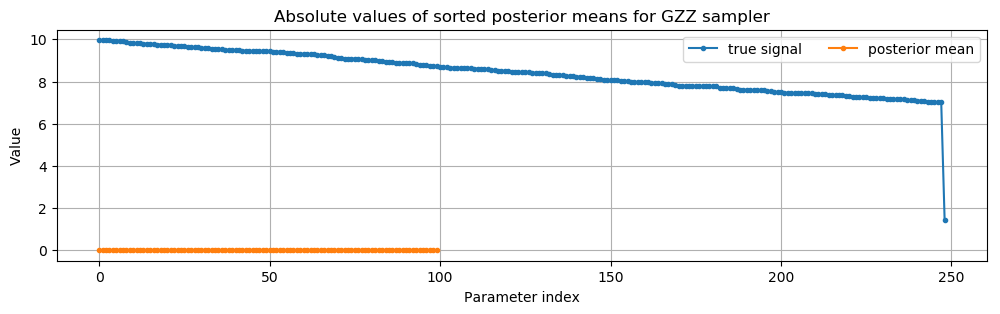

PyObject Text(24.000000000000007, 0.5, 'Value')

In [22]:
fig = figure(figsize=(12,3))
plot(sort(abs.(ξ_true.nzval), rev=true), "o-", markersize=3, label="true signal")
plot(sort(vec(abs.(post_mean_gzz)), rev=true)[1:100], "o-", markersize=3, label="posterior mean")
# plot(sort(vec(abs.(post_median_gzz)), rev=true)[1:50], "o-", markersize=3, label="posterior median")
grid(true)
title("Absolute values of sorted posterior means for GZZ sampler")
legend(ncol=3)
xlabel("Parameter index")
ylabel("Value")

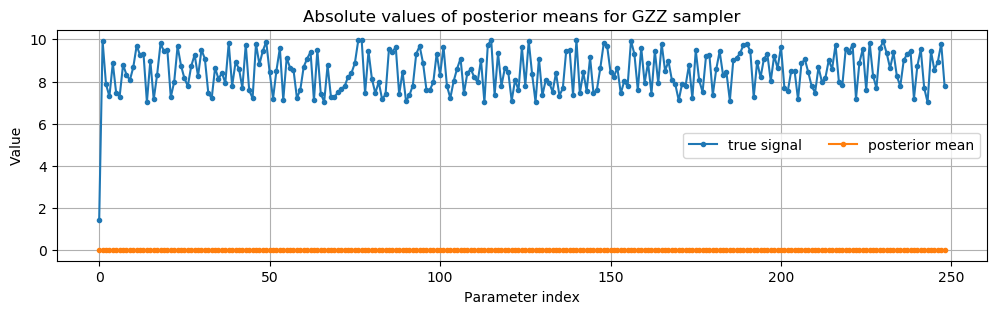

In [23]:
fig = figure(figsize=(12,3))
plot(abs.(ξ_true.nzval), "o-", markersize=3, label="true signal")
plot(vec(abs.(post_mean_gzz))[ξ_true.nzind], "o-", markersize=3, label="posterior mean")
grid(true)
title("Absolute values of posterior means for GZZ sampler")
legend(ncol=3)
xlabel("Parameter index")
ylabel("Value");